# By default hod subtract will run.To change it to hod concat please change RawTarget and RawData path

# Linear Regression HOD

In [662]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd;

In [663]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.9
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 9
PHI = []
IsSynthetic = False

In [664]:
#gives us target vector which consist actually i.e.0,1
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
            #print(int(row[0]))
    #print("Raw Training Generated..")
    return t

#gets features from file and deletes five columns because there values always zero in all rows
def GenerateRawData(filePath):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column)+0.0002);
            dataMatrix.append(dataRow) 
            #print(dataRow)
    
#     if IsSynthetic == False :
#         dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
   # print(dataMatrix.shape)
    dataMatrix = np.transpose(dataMatrix)  
   # print(dataMatrix.shape)
    #print ("Data Matrix Generated..")
    return dataMatrix

#gets target matrix 80% to compare results of training matrix result
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    #print(t)
    #print(TrainingLen)
    return t

#gets 80% rows as traning data 
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    #print(T_len)
    return d2

#gets validation matrix i.e. 10% of raw data
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#gets target matrix  10% to compare results of validation matrix result
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

#not using parameter MuMatrix,redundant parameter;its inverse to calculate Phi value, which is used to calculate basis function
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    #print(BigSigma)
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

#converts input vector to scalar value
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#calculates closed form solution with least square regularisation
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) 
    print(TrainingLen)
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

#find rms of dataset and our goal is to minimize this error
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

##generate key value pair of data set; key:imgae_id,value:features
def GenerateMap(filePath):
    Map = {}
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi);
        next(reader);
        for row in reader:
            i=0;
            list=[];
            for column in row:
                if(i==1):
                    key=column;
                elif(i>1) :
                    list.append(int(column));
                i=i+1
            Map[key] = list;
            #print(Map[key]);
    return Map;

##returns subtraction and concatination list of given csv image_id pairs
def GenerateConcatList(filePath,KVMap):
    Map = {}
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi);
        next(reader);
        sub = [];
        target = [];
        conca = [];
        for row in reader:
            i=0;
            c1=[];
            c2=[];
            for column in row:
                if(i==2):
                    target.append(int(column));
                elif(i==0) :
                    c1=KVMap[column];
                elif(i==1):
                    c2 = KVMap[column];
                i = i + 1;
            myList=c1+c2;
            myList.extend([int(column)])
            conca.append(myList);
            subtract=np.subtract(c1,c2);
            subtract=np.append(subtract,int(column));
            sub.append(subtract);

        Map["target"] = target;
        Map["sub"] = sub;
        Map["concat"] = conca;
            #print(Map[key]);
    return Map;

## Fetch and Prepare Dataset for HOD

In [665]:
#use hod cell to calculate erms for hod dataset

# RawTarget = GetTargetVector('HODtargetConcat.csv')
# RawData   = GenerateRawData('HODfeaturesConcat.csv')

RawTarget = GetTargetVector('HODtargetSub.csv')
RawData   = GenerateRawData('HODfeaturesSub.csv')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 'U' mode is deprecated
  from ipykernel import kernelapp as app


## Prepare Training Data

In [666]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(1266,)
(9, 1266)


## Prepare Validation Data

In [667]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(9, 158)


## Prepare Test Data

In [668]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(9, 158)


# Gradient Descent solution (HOD) for Linear Regression

# Calculating phi matrix

In [669]:
M1=9
ErmsArr = []
AccuracyArr = []
#Using K-means clustering to find basis function.
kmeans = KMeans(n_clusters=M1, random_state=0).fit(np.transpose(TrainingData))
#setting the value of centroid for Gaussian Radial basis function
Mu = kmeans.cluster_centers_

#whole block of below lines perform linear regression,which is used to find Erms.
#generates diagonal matrix.
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
#print(BigSigma)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

1266
157
158
(9, 9)
(9, 9)
(1266, 9)
(9,)
(158, 9)
(157, 9)


1266
----------Gradient Descent Solution--------------------
 
M =  9
Lambda  =  2 
learningRate=  0.01
E_rms Training   = 0.50324
E_rms Validation = 0.50321
E_rms Testing    = 0.50134
Accuracy of testing data    = 54.14013


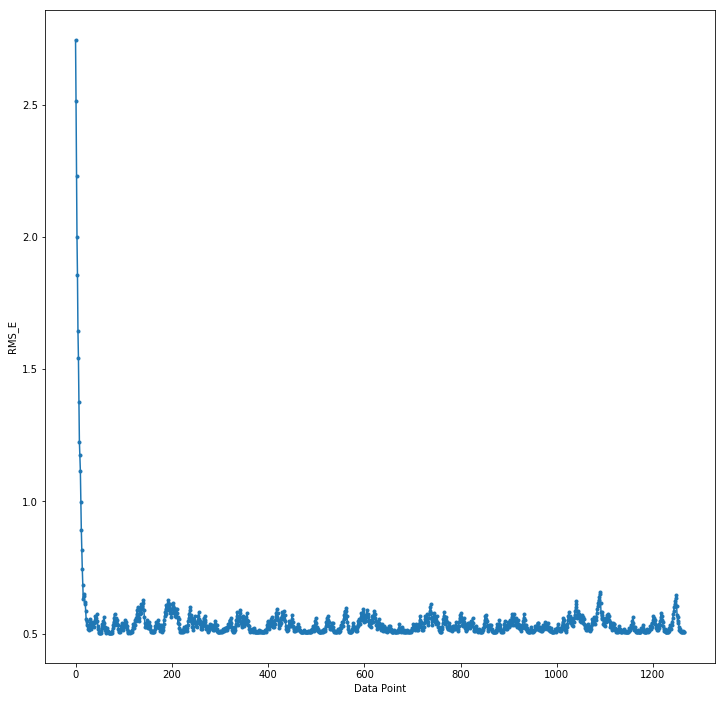

In [670]:
#Scaling the weights because of their initial size.
W=np.random.normal(loc = 0.0, scale = 0.02, size = (M1,))
W_Now        = np.dot(256, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

accuracy = []
#We can iterate through all the training data.But it is time consuming task.
#You can stop early, if weights are stagnant i.e.Erms is stagnant
#In the python code, we observed stagnant weights after some iterations (datapoints).
#It means we don't see any improvement in our model after some datapoints.Because of this keeping for loop from
#1-800 or len(TrainingTarget)
print(len(TrainingTarget));
#selecting dataset size for hod and gsc
loop=len(TrainingTarget);
for i in range(0,len(TrainingTarget)):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    accuracy.append(float(Erms_Test.split(',')[0]))

print ('----------Gradient Descent Solution--------------------')
print (" \nM = ",M1)
print ("Lambda  = ", La,"\nlearningRate= ",learningRate)
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy of testing data    = " + str(np.around(max(accuracy),5)))

y = L_Erms_Test
x = []
for i in range(0,loop):
    x.append(i);
#x = LaVal
plt.figure(figsize=[8, 8])
plt.ylabel('RMS_E')
plt.xlabel('Data Point')
plt.plot(x,y,marker='.')
plt.show()